# Imports & Visualisation

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data = pd.read_csv('final_dataset.csv')

In [3]:
data.head()

,Domain,Num_words,Num_chars,Hyphen,Entropy_sdsu,Entropy_nosdsu,Entropy_nosu,Tranco_Rank,Longest_word_ratio,Typos,Freenom_TLD,Other_numbers,Subdomain levels,Label
0,webmail.covid.mataroma.ma.gov.br,8,30,0,3.625807,2.155639,3.606937,0,0.218750,0,0,0,2,0
1,coronaparser.cf,3,14,0,3.189898,2.855389,2.855389,0,0.400000,0,1,0,0,1
2,coronavirus.paranavai.pr.gov.br,6,29,0,3.446807,2.281036,3.232102,0,0.354839,0,0,0,1,0
3,covid19immunitystaffing.com,6,26,0,3.912114,3.827910,3.827910,0,0.296296,0,0,0,0,1
4,covid19scanning.com,5,18,0,3.536887,3.323231,3.323231,0,0.421053,0,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67616 entries, 0 to 67615
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Domain              67616 non-null  object 
 1   Num_words           67616 non-null  int64  
 2   Num_chars           67616 non-null  int64  
 3   Hyphen              67616 non-null  int64  
 4   Entropy_sdsu        67616 non-null  float64
 5   Entropy_nosdsu      67616 non-null  float64
 6   Entropy_nosu        67616 non-null  float64
 7   Tranco_Rank         67616 non-null  int64  
 8   Longest_word_ratio  67616 non-null  float64
 9   Typos               67616 non-null  int64  
 10  Freenom_TLD         67616 non-null  int64  
 11  Other_numbers       67616 non-null  int64  
 12  Subdomain levels    67616 non-null  int64  
 13  Label               67616 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 7.2+ MB


## Countplot

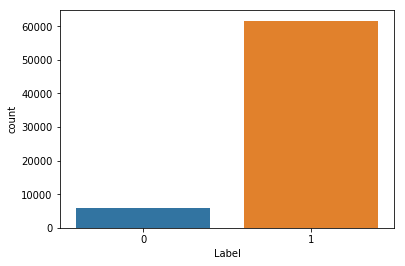

In [5]:
sns.countplot(data['Label'])

## Histograms

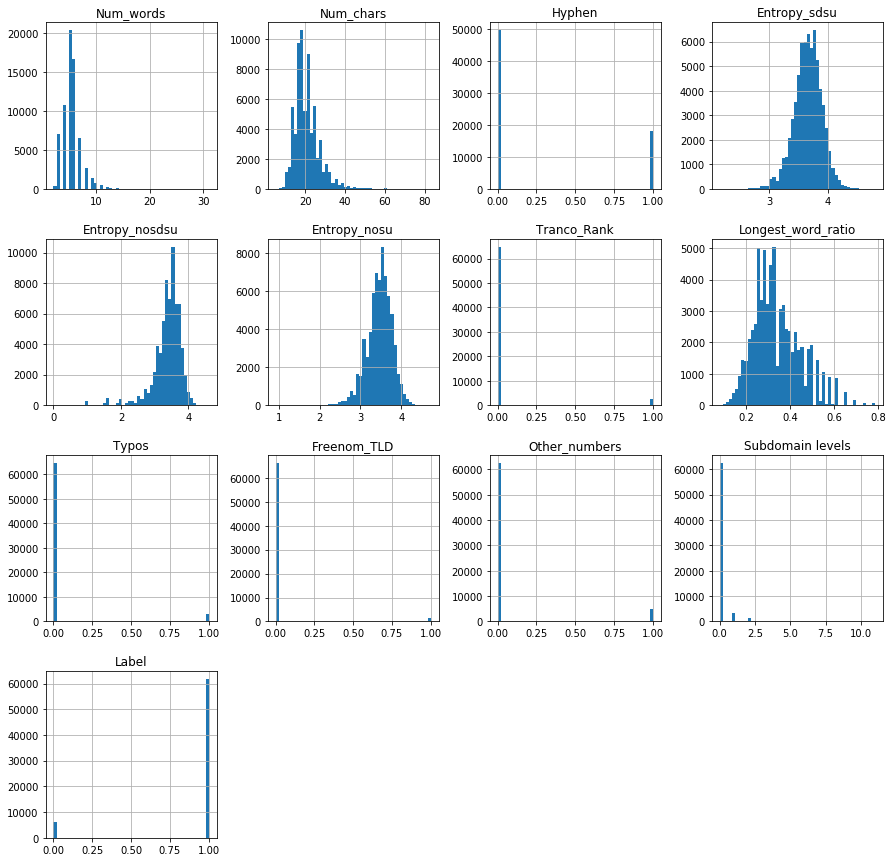

In [6]:
data.hist(bins = 50,figsize = (15,15))
plt.show()

## Correlation heatmap

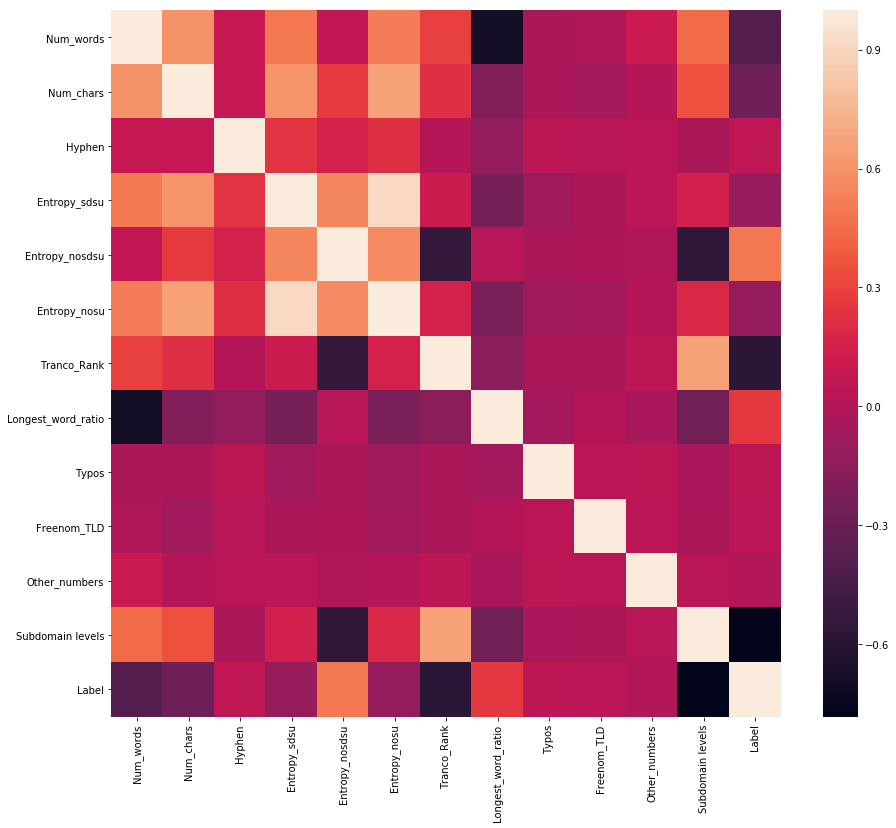

In [7]:
plt.figure(figsize=(15,13))
sns.heatmap(data.corr())
plt.show()

## Decription

In [8]:
data.describe()

,Num_words,Num_chars,Hyphen,Entropy_sdsu,Entropy_nosdsu,Entropy_nosu,Tranco_Rank,Longest_word_ratio,Typos,Freenom_TLD,Other_numbers,Subdomain levels,Label
count,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000
mean,5.435666,20.748506,0.267599,3.665614,3.379876,3.465380,0.040153,0.341286,0.044102,0.020823,0.074775,0.106232,0.911692
std,1.763676,6.200718,0.442711,0.236599,0.426790,0.299440,0.196320,0.108258,0.205323,0.142794,0.263030,0.411330,0.283744
min,2.000000,5.000000,0.000000,2.155639,-0.000000,0.918296,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,17.000000,0.000000,3.521641,3.238901,3.281036,0.000000,0.263158,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,20.000000,0.000000,3.682006,3.454822,3.499228,0.000000,0.322581,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.000000,24.000000,1.000000,3.825252,3.640224,3.664498,0.000000,0.407407,0.000000,0.000000,0.000000,0.000000,1.000000
max,31.000000,83.000000,1.000000,4.810857,4.602213,4.723606,1.000000,0.785714,1.000000,1.000000,1.000000,11.000000,1.000000


# Preprocessing

In [9]:
X = data.drop(['Domain', 'Label'], axis=1)
y = data['Label']

In [10]:
X.shape, y.shape

((67616, 12), (67616,))

In [13]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['black', 'red']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
        sns.despine()
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

## Undersampling

### Default NearMiss

In [28]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

X_nearmiss, y_nearmiss = NearMiss(sampling_strategy=0.25).fit_sample(X, y)

Counter({1: 23884, 0: 5971})


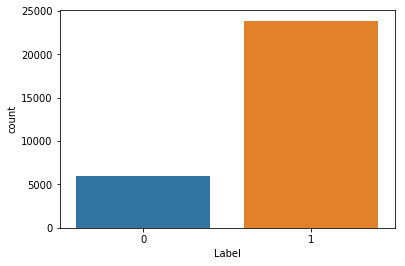

In [29]:
sns.countplot(y_nearmiss)
print(Counter(y_nearmiss))

# Algorithms

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import tree
import graphviz

In [22]:
scoring = ['precision', 'recall', 'f1', 'accuracy']

In [40]:
def append_avgs(dict):
    avgs = []
    stds = []
    for i in dict:
        avg = np.average(dict[i])
        std = np.std(dict[i])
        avgs.append(avg)
        stds.append(std)
    df = pd.DataFrame(dict)
    df.loc[10] = avgs
    df.loc[11] = stds
    return df

def get_avg(df):
    return df.iloc[[10]].reset_index(drop=True)

def draw(dict):
    folds = list(range(0,10))
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(folds,dict['test_accuracy'][:10],label='accuracy',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_precision'][:10],label = 'precision',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_f1'][:10],label = 'f1 score',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_recall'][:10],label='Recall',marker='o', linestyle='--',)
    plt.xlabel('Fold')
    plt.ylabel('Performance')
    plt.xticks(folds, folds)
    plt.legend()
    plt.show()

## Decision Tree

In [23]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

In [59]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_nearmiss, y_nearmiss, test_size=0.333333, random_state=100)

### Baseline

#### Previously Undersampled

In [96]:
# instantiate the model 
dtc = DecisionTreeClassifier()
# fit the model 

dtc.fit(X_train_1, y_train_1)

DecisionTreeClassifier()

In [97]:
dtc_test_pred = dtc.predict(X_test_1)

In [98]:
print("The DTC's classification report:\n\n",classification_report(y_test_1, dtc_test_pred))
print("The DTC's confusion matrix:\n\n",confusion_matrix(y_test_1, dtc_test_pred))

The DTC's classification report:

               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1976
           1       0.98      0.97      0.97      7976

    accuracy                           0.96      9952
   macro avg       0.93      0.94      0.94      9952
weighted avg       0.96      0.96      0.96      9952

The DTC's confusion matrix:

 [[1800  176]
 [ 225 7751]]


In [101]:
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names=X.columns,
                                class_names=["whitelist","malicious"],
                                filled=True, rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('test-output/decision_tree.gv', view=True)

'test-output\\decision_tree.gv.pdf'

In [ ]:
graph

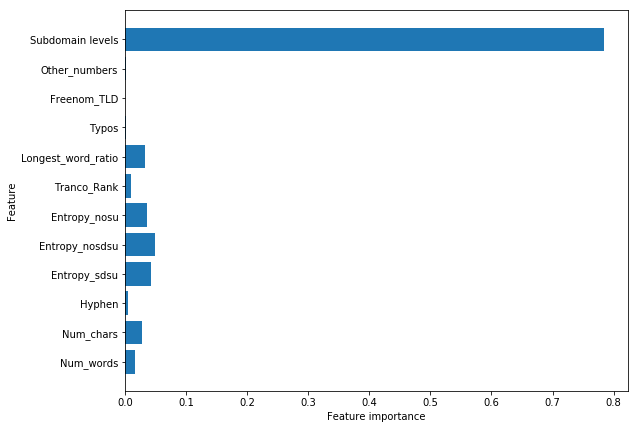

In [99]:
plt.figure(figsize=(9,7))
n_features = X_train_1.shape[1]
plt.barh(range(n_features), dtc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train_1.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


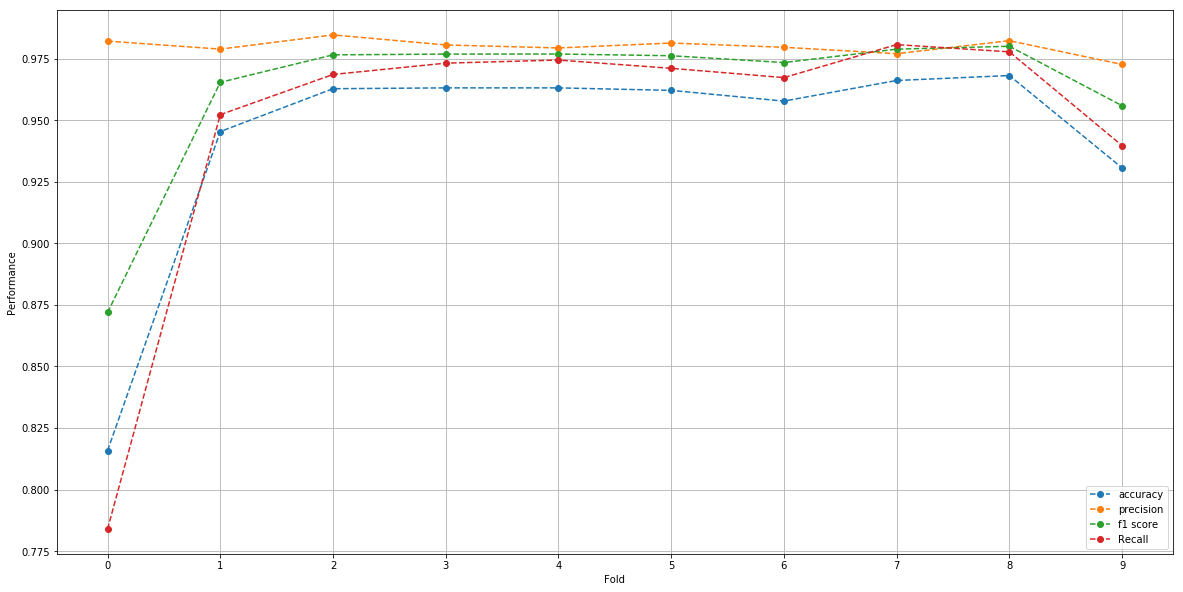

In [66]:
clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dtc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
dtc_sc_pr = append_avgs(dtc_sc_pr)
draw(dtc_sc_pr)

#### Undersampled in pipeline

In [57]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), DecisionTreeClassifier())
dtc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
dtc_sc = append_avgs(dtc_sc)

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


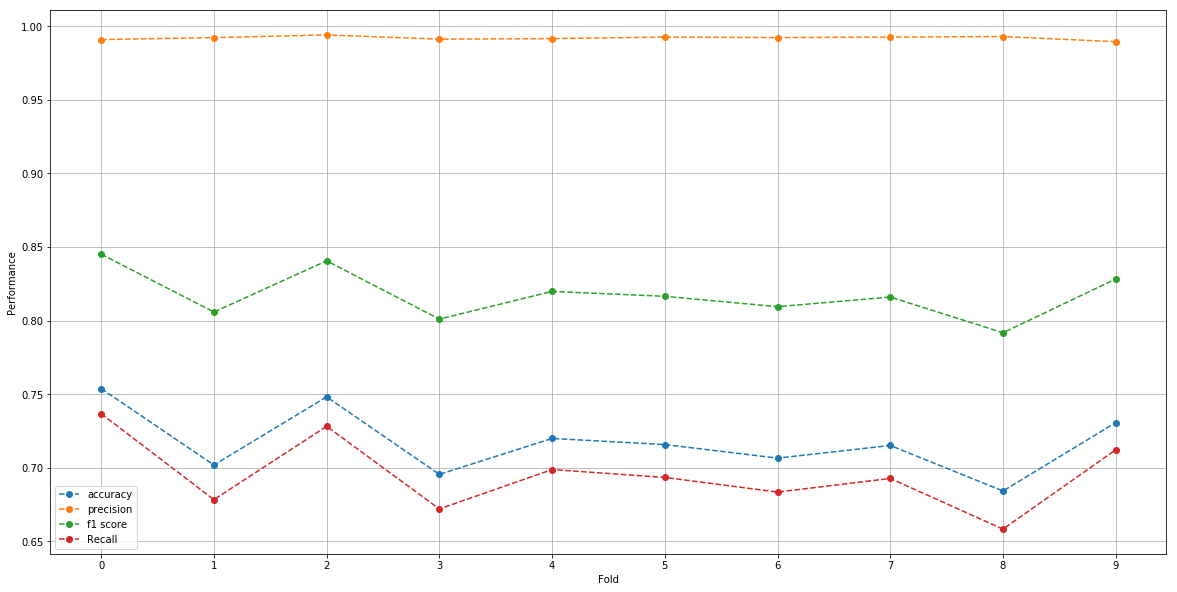

In [58]:
draw(dtc_sc)

## Random Forest

In [44]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

### Baseline

#### Previously Undersampled

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


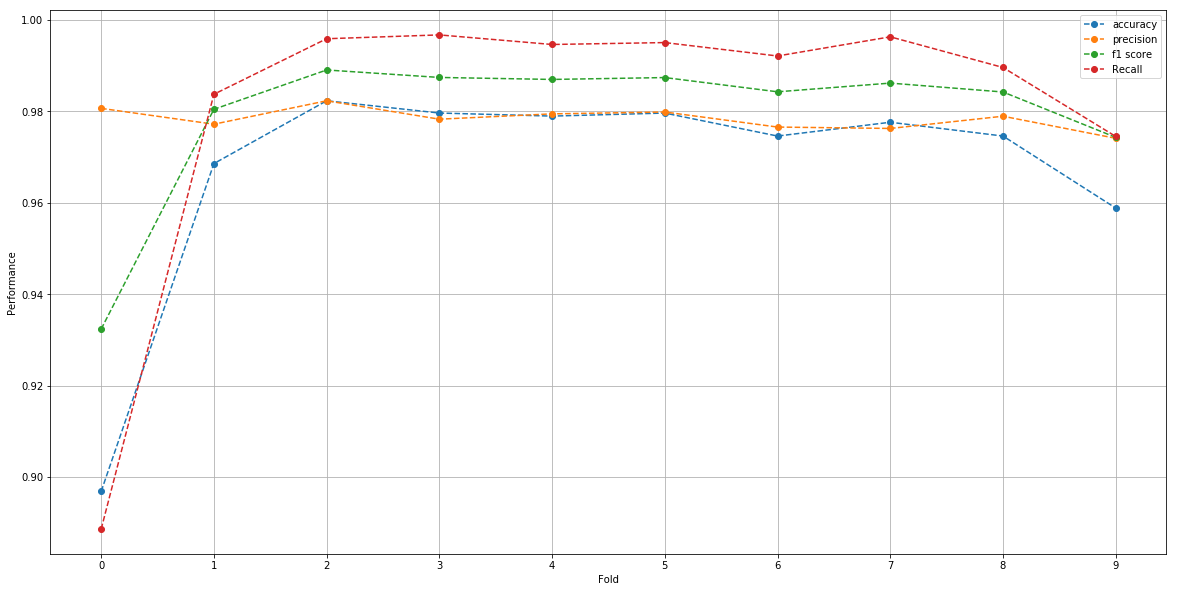

In [67]:
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
rfc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
rfc_sc_pr = append_avgs(rfc_sc_pr)
draw(rfc_sc_pr)

#### Undersampled in pipeline

In [53]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), RandomForestClassifier())
rfc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
rfc_sc = append_avgs(rfc_sc)

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


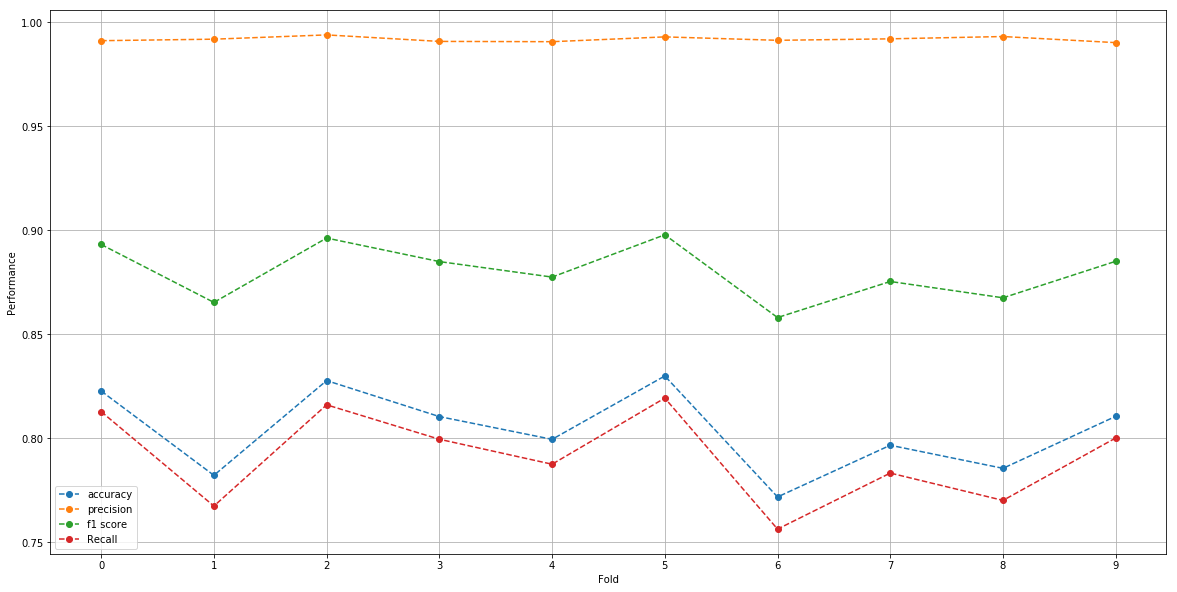

In [54]:
draw(rfc_sc)

## XGBoost

In [50]:
# XGboost classifier
from xgboost import XGBClassifier

H:\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
H:\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


### Baseline

#### Previously Undersampled

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


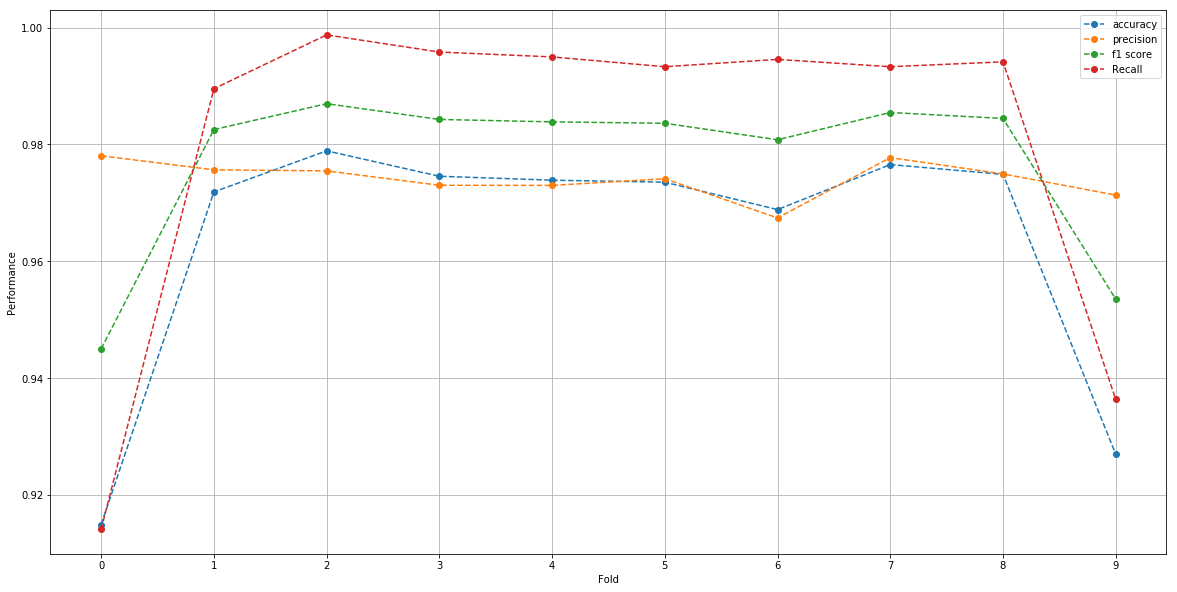

In [68]:
clf = make_pipeline(StandardScaler(), XGBClassifier())
xgb_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
xgb_sc_pr = append_avgs(xgb_sc_pr)
draw(xgb_sc_pr)

#### Undersampled in pipeline

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


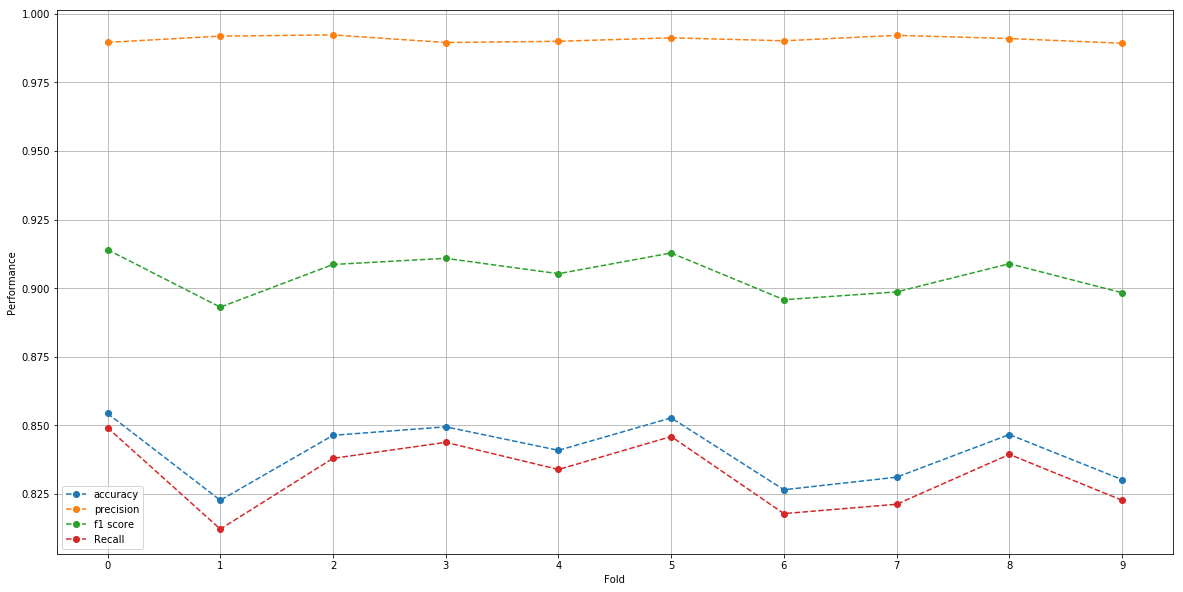

In [56]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), XGBClassifier())
xgb_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
xgb_sc = append_avgs(xgb_sc)

draw(xgb_sc)

## GBC

In [69]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

### Baseline

#### Previously Undersampled

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


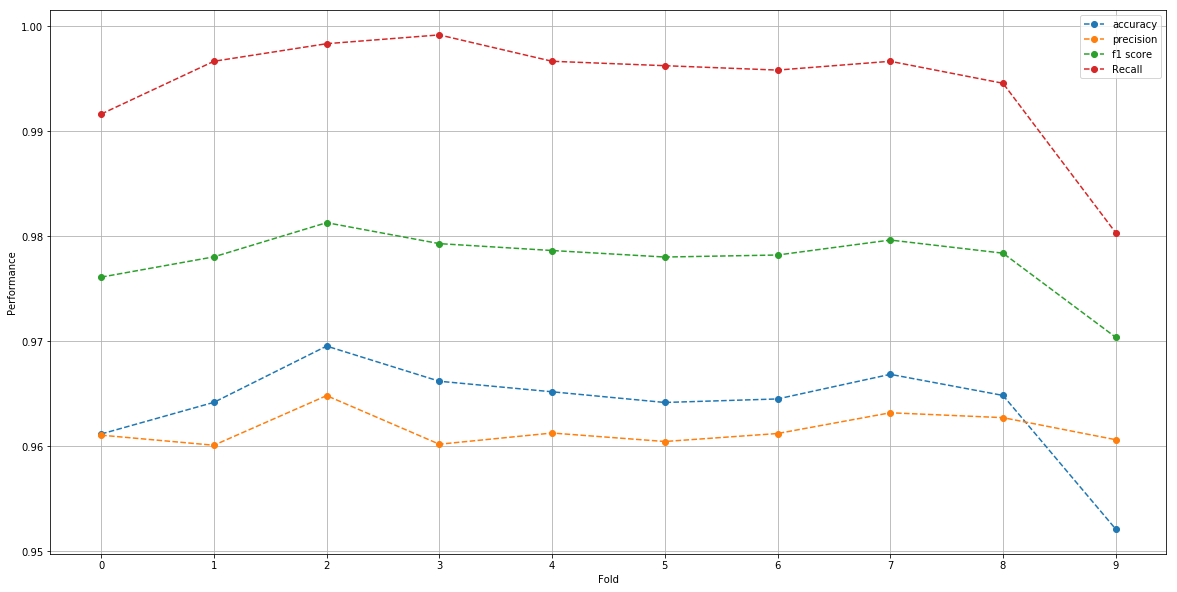

In [70]:
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gb_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
gb_sc_pr = append_avgs(gb_sc_pr)
draw(gb_sc_pr)

#### Undersampled in pipeline

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


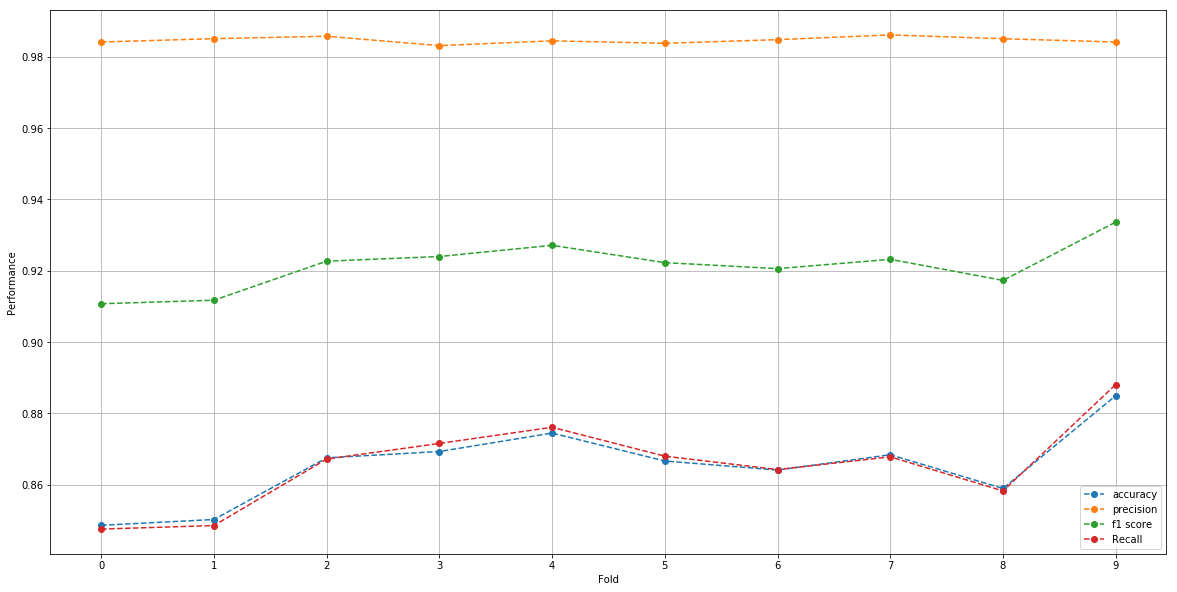

In [77]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), GradientBoostingClassifier())
gb_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
gb_sc = append_avgs(gb_sc)

draw(gb_sc)

## Perceptron

In [78]:
from sklearn.neural_network import MLPClassifier

### Baseline

#### Previously Undersampled

H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, n

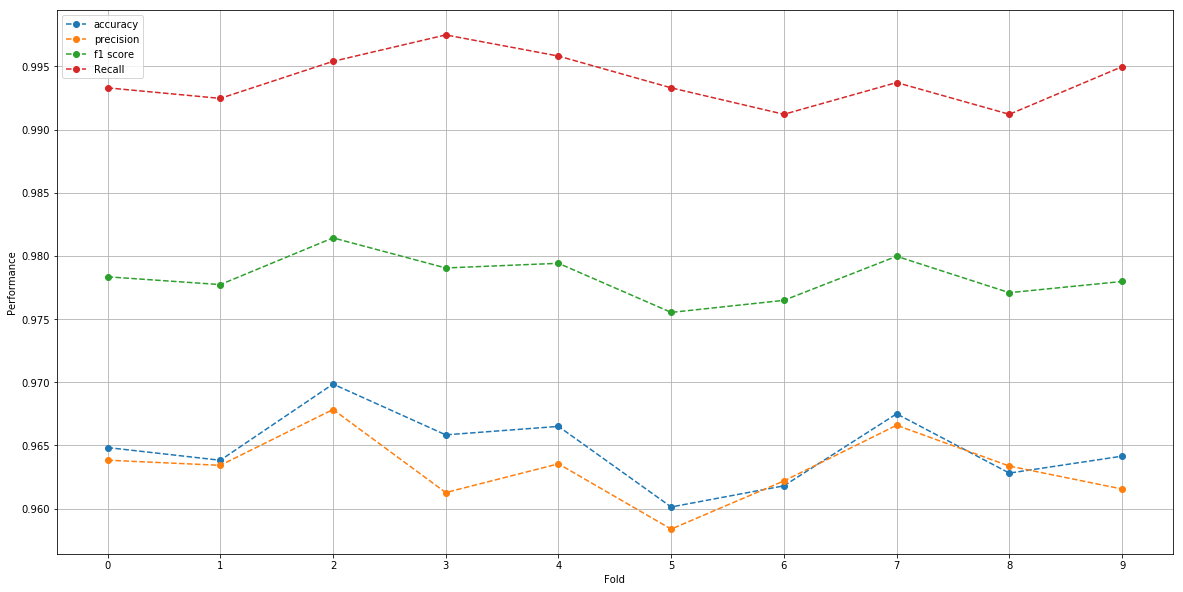

In [79]:
clf = make_pipeline(StandardScaler(), MLPClassifier())
mlp_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
mlp_sc_pr = append_avgs(mlp_sc_pr)
draw(mlp_sc_pr)

#### Undersampled in pipeline

H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
H:\Anaconda3\lib\site-packages\m

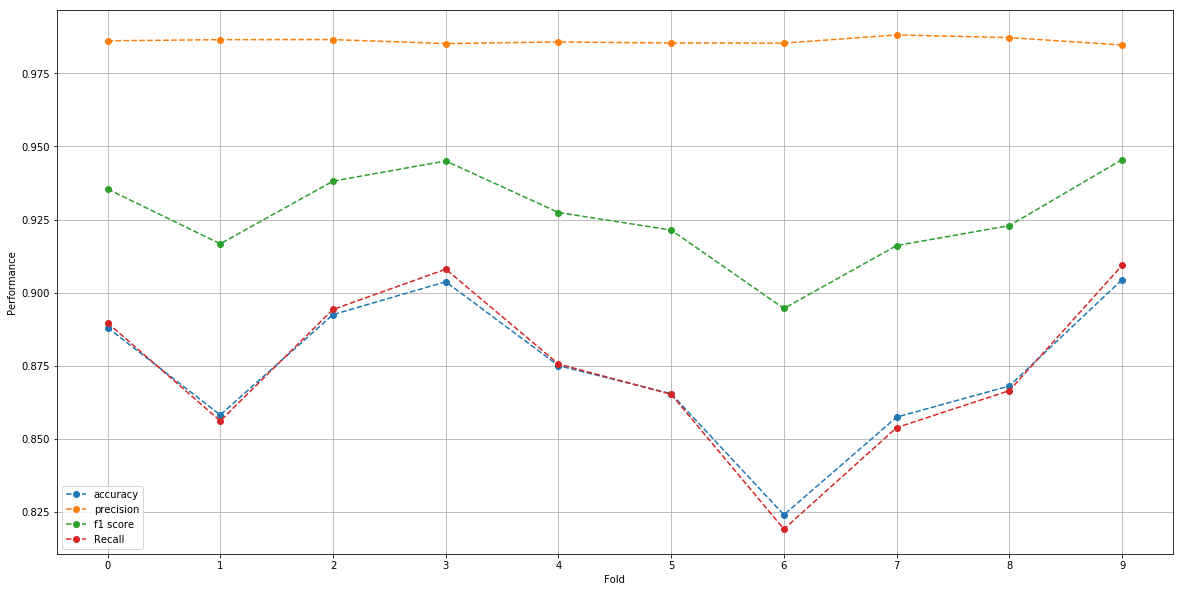

In [80]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), MLPClassifier())
mlp_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
mlp_sc = append_avgs(mlp_sc)

draw(mlp_sc)

## SVM

In [81]:
from sklearn.svm import SVC

### Baseline

#### Previously Undersampled

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


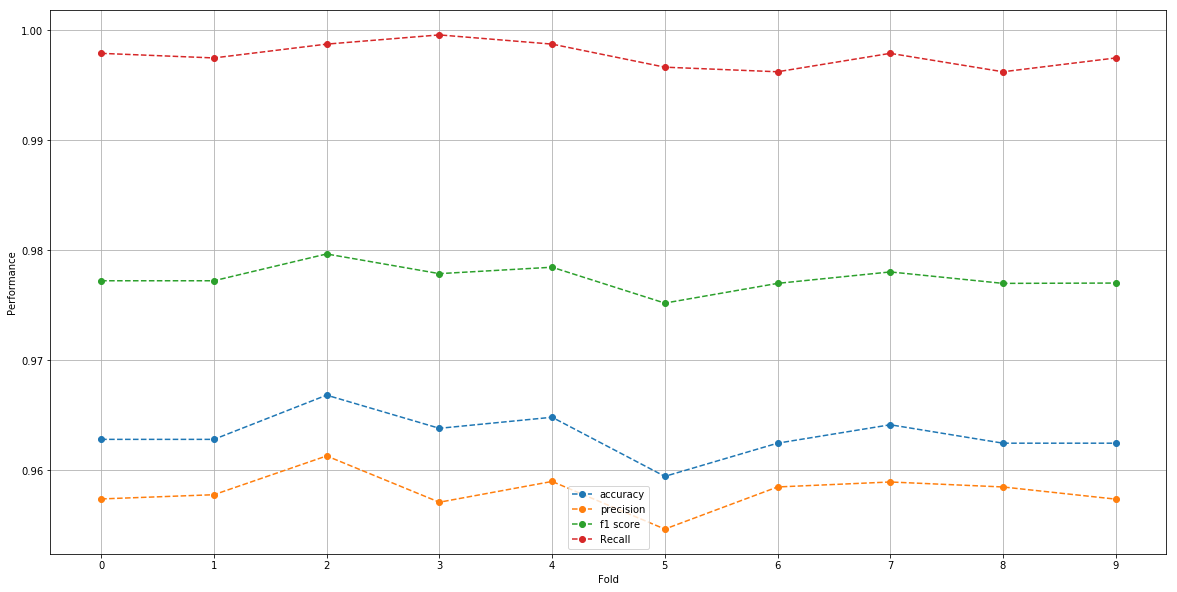

In [82]:
clf = make_pipeline(StandardScaler(), SVC(verbose=1))
svc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
svc_sc_pr = append_avgs(svc_sc_pr)
draw(svc_sc_pr)

#### Undersampled in pipeline

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
H:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


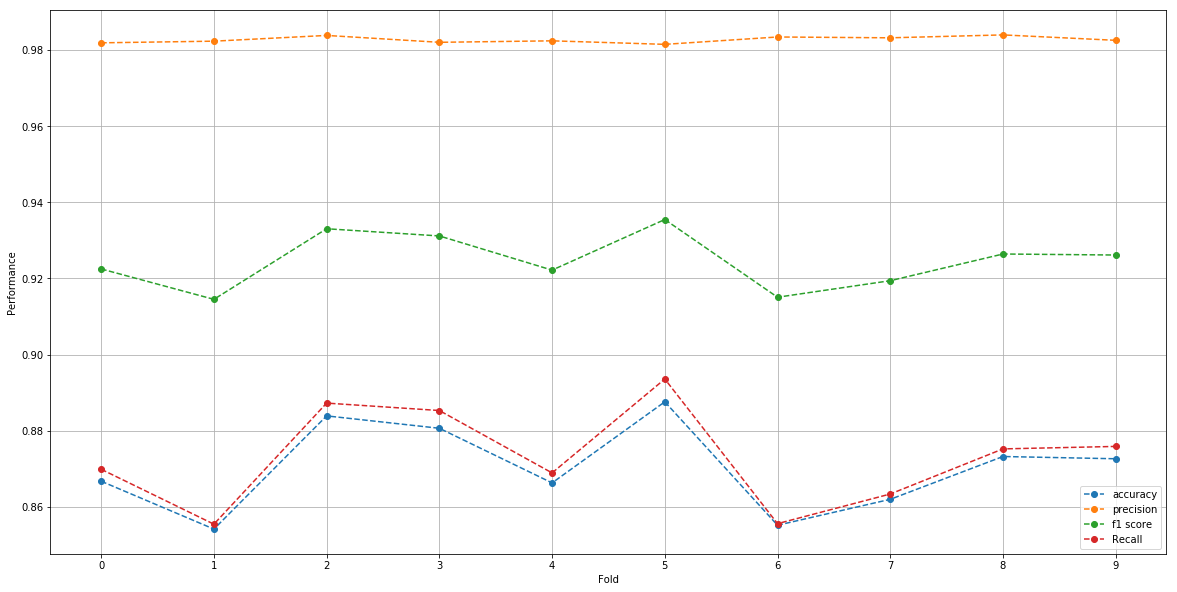

In [83]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), SVC(verbose=1))
svc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
svc_sc = append_avgs(svc_sc)

draw(svc_sc)